In [1]:
import torch
import torch.nn as nn

In [2]:
# now i can define the blocks that i need ...

class resnetBlock(nn.Module):
    
        def __init__(self, in_channels, out_channels, activation = nn.LeakyReLU()):
            super().__init__()
            self.activation = activation
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3,stride = 1,  padding=1)
            self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride = 1, padding=1)

                    # nn.(8, in_channels if i == 0 else out_channels),
            self.bn1 = nn.BatchNorm2d(in_channels)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.in_channels = in_channels
            self.out_channels = out_channels
            
            self.res_input_conv = nn.Conv2d(in_channels, out_channels, 1)

        def forward(self, x):
            input = x
            #print(self.bn1)
            #print("Before bn1:", x.shape)

            x = self.bn1(x)
            x = self.activation(x)
            x = self.conv1(x)
            x = self.bn2(x)
            x = self.activation(x)
            x = self.conv2(x)
            x = x + self.res_input_conv(input)
            return x
        
class selfAttentionBlock(nn.Module):

    def __init__(self,in_channels, out_channels, headnums, activation = nn.LeakyReLU()):
        super().__init__()
        self.activation = activation
        self.norm = nn.GroupNorm(8, out_channels)
        self.satt = nn.MultiheadAttention(out_channels, headnums, batch_first=True)
        self.inConv = nn.Conv2d(in_channels, out_channels, 1)
        
    def forward(self,x):
        input = x
        self.b, self.c, self.h, self.w = x.shape
        #print("Before reshape:", x.shape)
        x = x.reshape(self.b, self.c, self.h * self.w) #reshape to linear ... 
        #print("After reshape:", x.shape)

        x = self.norm(x)
        #print("After norm:", x.shape)
        x = x.transpose(1,2) # to put channels as last dimension ...
        x, _ = self.satt(x, x , x)
        #print("After self att:", x.shape)
        x = x.transpose(1, 2).reshape(self.b, self.c, self.h, self.w) #reshape back to original shape
        #print("After reshape x:", x.shape)
        #print("After reshape in:", input.shape)

        x = input + x
        return x

In [3]:
# and now i can define the 3 types of block (downBlock, upBlock, middleBlock)
# check reference video for more details ...

class downBlock(nn.Module):
    def __init__(self,in_channels, out_channels, downsample ,num_layers = 1):
        super().__init__()
        self.num_layers = num_layers
        self.downsample = downsample

        self.down_sample_conv = nn.Conv2d(out_channels, out_channels, 4, 2, 1) if self.downsample else nn.Identity()

        self.resnet = nn.ModuleList([
            resnetBlock(in_channels if i == 0 else out_channels, out_channels)
            for i in range(num_layers)
        ])
        self.selfatt =nn.ModuleList([
            selfAttentionBlock(out_channels, out_channels, 4)
            for _ in range(num_layers)
            ])

    def forward(self, x):
        for i in range(self.num_layers):
            x = self.resnet[i](x) 
            x = self.selfatt[i](x)
        
        x = self.down_sample_conv(x)
        return x

In [4]:
class middleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers=1):
        super().__init__()
        self.num_layers = num_layers

        self.initialResnet = resnetBlock(in_channels, out_channels)
        
        self.resnet = nn.ModuleList([
            resnetBlock(out_channels, out_channels)
            for _ in range(num_layers)
        ])
        self.selfatt = nn.ModuleList([
            selfAttentionBlock(out_channels, out_channels, 4)
            for _ in range(num_layers)
        ])

    def forward(self, x):

        x = self.initialResnet(x)
        
        for i in range(self.num_layers):
            x = self.selfatt[i](x)
            x = self.resnet[i](x)
        return x

In [5]:

class upBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample, num_layers=1,skip_connections = False):
        super().__init__()
        self.num_layers = num_layers
        self.upsample = upsample
        self.skip_connections = skip_connections

        self.up_sample_conv = nn.ConvTranspose2d(in_channels, in_channels, 4, 2, 1) if self.upsample else nn.Identity()

        self.resnet = nn.ModuleList([
            resnetBlock(in_channels if i == 0 else out_channels, out_channels)
            for i in range(num_layers)
        ])
        
        self.selfatt = nn.ModuleList([
            selfAttentionBlock(out_channels, out_channels, 4)
            for _ in range(num_layers)
        ])

    def forward(self, x,downblock_out = None):

        x = self.up_sample_conv(x)
        if self.skip_connections: 
            x = x + downblock_out
        
        for i in range(self.num_layers):
            
            x = self.resnet[i](x)
            x = self.selfatt[i](x)
        return x

In [6]:
# unet 

class unet(nn.Module):

    def __init__(self, in_channels,activation = nn.LeakyReLU(), num_layers=1,skip_connections = False):
        super().__init__()
        self.down_channels = [32,64,128,256] 
        self.middle_channels = [256,256,128]
        self.up_channels = [128,64,32,16]
        self.downsample = [True, True, False]
        self.upsample = list(reversed(self.downsample))
        self.num_layers = num_layers
        self.activation = activation
        self.skip_connections = skip_connections

        self.input_conv = nn.Conv2d(in_channels, self.down_channels[0], 3, padding=1)

        self.down_blocks = nn.ModuleList()

        for i in range(len(self.down_channels ) - 1):
            self.down_blocks.append( 
                downBlock(self.down_channels[i], self.down_channels[i+1], self.downsample[i], num_layers)
            )
        self.mid_blocks = nn.ModuleList()

        for i in range(len(self.middle_channels) - 1):
            self.mid_blocks.append(
                middleBlock(self.middle_channels[i], self.middle_channels[i+1], num_layers)
            )

        self.up_blocks = nn.ModuleList()

        for i in range(len(self.up_channels) - 1):
            self.up_blocks.append(
                upBlock(self.up_channels[i], self.up_channels[i+1], self.upsample[i], num_layers)
            )        

        # final conversion to same shape as input ...
        self.output_norm = nn.GroupNorm(8,self.up_channels[-1])
        self.output_conv = nn.Conv2d(self.up_channels[-1], in_channels, 3, padding=1)



    # adding c to condition ...
    def forward(self, x):
        x = self.input_conv(x)
        downblock_outs = []

        for i in range(len(self.down_blocks)):
            if(self.skip_connections):
                downblock_outs.append(x)
            x = self.down_blocks[i](x)

        for i in range(len(self.mid_blocks)):
            x = self.mid_blocks[i](x)
        
        for i in range(len(self.up_blocks)): 
            if(self.skip_connections):
                dout = downblock_outs.pop()
                x = self.up_blocks[i](x, dout)
            else:
                x = self.up_blocks[i](x)
        
        x = self.output_norm(x)
        x = self.activation(x)
        x = self.output_conv(x)
        return x


In [7]:
# just to test my implementation (from the reference video)
import glob
import os

import torchvision
from PIL import Image
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import numpy as np


class MnistDataset(Dataset):
    r"""
    Nothing special here. Just a simple dataset class for mnist images.
    Created a dataset class rather using torchvision to allow
    replacement with any other image dataset
    """
    def __init__(self, split, im_path, im_ext='png'):
        r"""
        Init method for initializing the dataset properties
        :param split: train/test to locate the image files
        :param im_path: root folder of images
        :param im_ext: image extension. assumes all
        images would be this type.
        """
        self.split = split
        self.im_ext = im_ext
        self.images, self.labels = self.load_images(im_path)
    
    def load_images(self, im_path):
        r"""
        Gets all images from the path specified
        and stacks them all up
        :param im_path:
        :return:
        """
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
        ims = []
        labels = []
        for d_name in tqdm(os.listdir(im_path)):
            for fname in glob.glob(os.path.join(im_path, d_name, '*.{}'.format(self.im_ext))):
                ims.append(fname)
                labels.append(int(d_name))
       #print('Found {} images for split {}'.format(len(ims), self.split))
        return ims, labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        im = Image.open(self.images[index])
        
        im_tensor = torchvision.transforms.ToTensor()(im)
        # Convert input to -1 to 1 range.
        #im_tensor = (2 * im_tensor) - 1
        return im_tensor

100%|██████████| 10/10 [00:00<00:00, 91.77it/s]


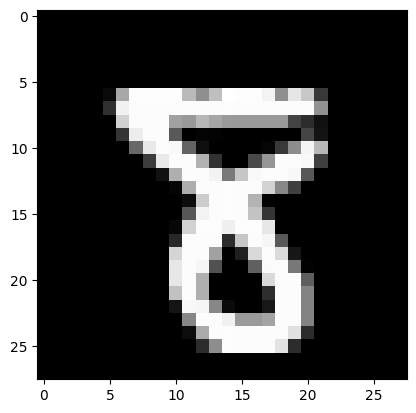

In [8]:
import matplotlib.pyplot as plt

im = MnistDataset('train', im_path="../data/train/images").__getitem__(0)

plt.imshow(im[0], cmap='gray')
plt.show()

In [9]:
BATCH_SIZE = 96
NUM_EPOCHS = 5

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)
from torch.optim import Adam
import matplotlib.pyplot as plt
from pytorch_msssim import SSIM

def train(model):
    
    # Create the dataset
    mnist = MnistDataset('train', im_path="../data/train/images")
    mnist_loader = DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
    model.train()
    # Create output directories
    if not os.path.exists("out"):
        os.mkdir("out")
    
    # Specify training parameters
    optimizer = Adam(model.parameters(), lr=0.0001)

    ssim = SSIM(data_range=1.0, size_average=True, channel=1, nonnegative_ssim=True)
    mae = nn.L1Loss()
    
    # Run training
    for epoch_idx in range(NUM_EPOCHS):
        losses = []
        if device.type == 'cuda':
             torch.cuda.empty_cache()
        lastimg = None
        lastReco = None
        for image in tqdm(mnist_loader):
            optimizer.zero_grad()
            image = image.float().to(device)

            reconstructed = model(image)

            loss = 1 - ssim(image, reconstructed) + mae(image, reconstructed)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            lastimg = image
            lastReco = reconstructed


        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(lastimg[0][0].detach().cpu(), cmap='gray')
        axs[0].set_title('image')
        axs[1].imshow(lastReco[0][0].detach().cpu(),cmap='gray')
        axs[1].set_title('reconstructed')
        plt.show()
        print('Finished epoch:{} | Loss : {:.4f}'.format(
            epoch_idx + 1,
            np.mean(losses),
        ))
        torch.save(model.state_dict(), os.path.join("out_vae",
                                                    "m1.pth"))
    
    print('Done Training ...')

Using device: cuda


In [11]:
model = unet(1).to(device)

100%|██████████| 625/625 [03:42<00:00,  2.81it/s]


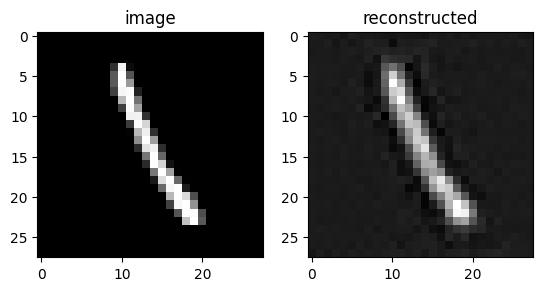

Finished epoch:1 | Loss : 0.3584


100%|██████████| 625/625 [03:41<00:00,  2.82it/s]


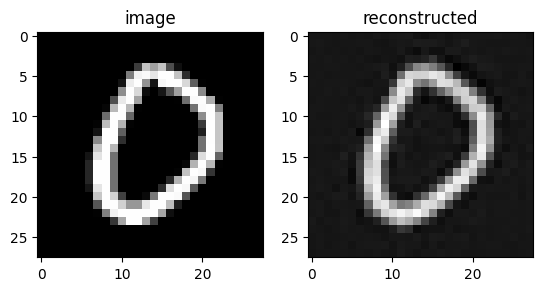

Finished epoch:2 | Loss : 0.0848


100%|██████████| 625/625 [03:34<00:00,  2.91it/s]


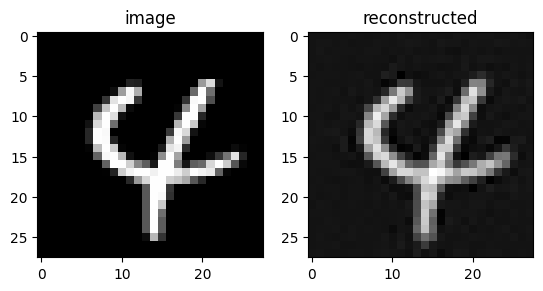

Finished epoch:3 | Loss : 0.0634


100%|██████████| 625/625 [03:36<00:00,  2.89it/s]


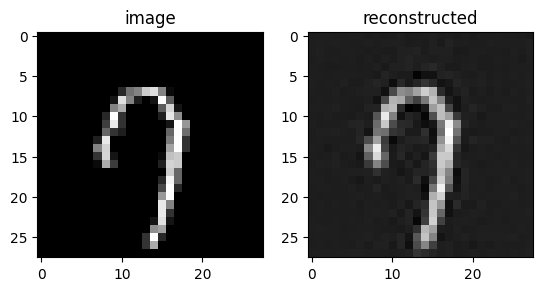

Finished epoch:4 | Loss : 0.0515


100%|██████████| 625/625 [03:41<00:00,  2.83it/s]


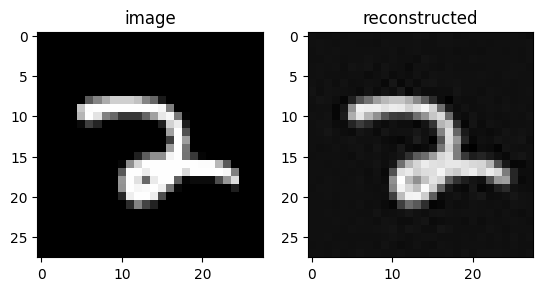

Finished epoch:5 | Loss : 0.0425
Done Training ...


In [12]:
train(model)